# Getting Started

In this notebook, we have developed code the show a full example of usage of the UnnobservedComponentsGAS.jl package.

## Import packages

In [7]:
import Pkg
Pkg.add(url = "https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using UnobservedComponentsGAS, Plots, CSV, DataFrames, Metrics

    Updating git-repo `https://github.com/LAMPSPUC/UnobservedComponentsGAS.git`
   Resolving package versions...
  No Changes to `C:\Users\matheuscn.ELE.000\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\matheuscn.ELE.000\.julia\environments\v1.8\Manifest.toml`


## Reading Airline Passengers data

First of all, one may want to visualize the time series data to be modeled and forecasted, while also leaving the last 12 timestamps as a validation set.

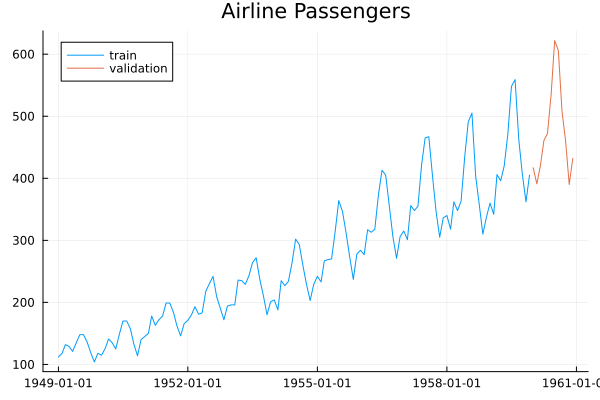

In [8]:
data = CSV.read("data/airline-passengers.csv", DataFrame)

steps_ahead = 12
y_train     = data[1:end-steps_ahead, 2]
y_val       = data[end-steps_ahead+1:end, 2] 
dates_train = data[1:end-steps_ahead, 1]
dates_val   = data[end-steps_ahead+1:end, 1]

plot(title = "Airline Passengers")
plot!(dates_train, y_train, label = "train")
plot!(dates_val, y_val, label = "validation")

## Define a Score-Driven Model

In order to create a GASModel object, one must specify some important informations, namely:
 - The model distribution;
 - Which parameters of the specified distribution will be time-varying;
 - The scale factor d to calculate the scaled score;
 - The level component dynamic for each parameter that is time-varying;
 - The seasonal component dynamic for each parameter that is time-varying, including the number seasonal periods;
 - The autoregressive component order for each parameter that is time-varying;

In thhe following example, we have created a GASModel with:
 - LogNormal distribution;
 - Only the first parameter as time-verying;
 - d = 1.0;
 - The level component as a random walk with slope;
 - The seasonal component as a deterministic seasonality with 12 seasonal periods;
 - No autoregressive component;

In [9]:
dist                    = UnobservedComponentsGAS.LogNormalDistribution()
time_varying_parameters = [true, false]
d                       = 1.0
level                   = ["random walk slope", ""]
seasonality             = ["deterministic 12", ""]
ar                      = [missing, missing]

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar);

## Fit a GASModel model

In order to fit the model we have created, we must simply call the function *fit*, passing the model created, the time series we wish to fit, and some auxiliar parameters, if wanted, as sample robustness and regularization $\alpha$. 

In [10]:
fitted_model = UnobservedComponentsGAS.fit(model, y_train; robust = false, α = 0.5);

┌ Info: Creating GAS model...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:41
┌ Info: Including parameters...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:49
┌ Info: Computing score...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:52
┌ Info: Including components...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:55
┌ Info: Computing initial values...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:58
┌ Info: Including dynamics..
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComponentsGAS\ec63P\src\fit.jl:64
┌ Info: Including objective funcion...
└ @ UnobservedComponentsGAS C:\Users\matheuscn.ELE.000\.julia\packages\UnobservedComp

In [22]:
fieldnames(typeof(fitted_model))

(:fit_in_sample, :fitted_params, :components, :selected_variables, :residuals, :information_criteria, :penalty_factor, :model_status)

The *fit* function returns a *Output* object that has the following fields and values:
 - :fit_in_sample: keeps the time series fitted values of the model
 - :fitted_params: keeps all the model's fitted params 
 - :components: keeps a dictionary with the fitted components of each time-varying parameter
 - :selected_variables: keeps the selected explanatory variables
 - :residuals: keeps a dictionary with the model's residuals
 - :information_criteria: keeps some informatin criteria, as the AIC and BIC
 - :penalty_factor: keep the regularization parameter $\alpha$
 - :model_status: keeps the optimization status

## Forecasting with the fitted model

In order to predict the future of the fitted model, we must use the function *predict*, passing the gas model, the fitted model, the vector of the fitted series, the number of steps ahead and the number of forecast scenarios. 

In [15]:
steps_ahead    = 12
num_scenarious = 500
forec = UnobservedComponentsGAS.predict(model, fitted_model, Float64.(y_train), steps_ahead, num_scenarious);

println(forec)
println(keys(forec))

Dict{String, Any}("scenarios" => [413.11434499821615 409.75098468055336 409.094498591964 414.8864468158002 417.8421015313873 419.88913431284715 416.1230172988334 422.2813820059405 410.2496928596989 417.50762731926585 418.264112118355 412.60787961331283 415.47388549318094 413.07646645039034 418.65687195924187 415.29404584928983 416.6481290720079 411.5752085430561 417.8966931079929 413.55838132078463 416.8786950729264 410.3711775493161 410.5212185971989 417.40846766996896 416.2439591813262 416.9295069046606 416.0279096764825 417.45330824936445 415.1438010913952 423.30958468836815 417.80902373460253 414.9497388971563 411.2904935842056 418.72678142609533 416.38678093314957 416.40780575255155 420.00937489607844 415.9100682786816 416.5011757461639 408.712126279722 420.4176676182102 420.5939154677101 418.3584049781357 408.9800054924362 416.69839654487004 422.27945624501126 407.7888344901538 408.6050255554921 416.7405108114512 418.2683899419904 419.7185955544209 414.407823953364 412.0029173865

## Final coments

Since this is just a getting started example, we will finish after obtaining the forecasted values, however, we strongly recommend that you explore the other examples we have developed in order to dive deeply into the package features.